In [1]:
# Базовые библиотеки: численные массивы + графики
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Разбиение на train/test и метрики качества
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Модель дерева + визуализация структуры и экспорт правил
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# “Быстрая интерпретация”: важность признаков через перемешивание (permutation importance)
from sklearn.inspection import permutation_importance

# Бейслайны
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Метрики
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

from sklearn.calibration import CalibratedClassifierCV

# Фиксируем случайность: так результаты на семинаре будут воспроизводимыми
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [32]:
# Считает метрики (accuracy, F1, ROC-AUC при наличии вероятностей)
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred, average="weighted")),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba, multi_class="ovr"))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

# Единообразная оценка модели на тесте
def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

In [ ]:
data = pd.read_csv("S06-hw-dataset-01.csv")


In [19]:
print(data.head())


   id       f01       f02       f03  ...       f26       f27       f28  target
0   1 -2.721419  0.652294  1.867234  ... -1.308459  2.155125  1.992519       0
1   2 -4.191520 -0.647731 -0.881929  ...  0.149833  4.861592 -3.547303       0
2   3 -0.582739  0.415128 -4.205613  ...  0.940883 -3.050749 -0.703865       1
3   4 -1.766082  1.253523  1.610804  ... -1.690537  8.687735 -2.799399       0
4   5 -2.157834 -1.361285 -0.917199  ... -0.718493  3.630457  0.083986       0

[5 rows x 30 columns]


In [20]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      15000 non-null  int64  
 1   f01     15000 non-null  float64
 2   f02     15000 non-null  float64
 3   f03     15000 non-null  float64
 4   f04     15000 non-null  float64
 5   f05     15000 non-null  float64
 6   f06     15000 non-null  float64
 7   f07     15000 non-null  float64
 8   f08     15000 non-null  float64
 9   f09     15000 non-null  float64
 10  f10     15000 non-null  float64
 11  f11     15000 non-null  float64
 12  f12     15000 non-null  float64
 13  f13     15000 non-null  float64
 14  f14     15000 non-null  float64
 15  f15     15000 non-null  float64
 16  f16     15000 non-null  float64
 17  f17     15000 non-null  float64
 18  f18     15000 non-null  float64
 19  f19     15000 non-null  float64
 20  f20     15000 non-null  float64
 21  f21     15000 non-null  float64
 22

In [21]:
print(data.describe())


                 id           f01  ...           f28        target
count  15000.000000  15000.000000  ...  15000.000000  15000.000000
mean    7500.500000     -0.840416  ...      0.150765      0.612600
std     4330.271354      1.785432  ...      2.005847      0.740016
min        1.000000     -8.199174  ...     -8.300728      0.000000
25%     3750.750000     -2.029608  ...     -1.235425      0.000000
50%     7500.500000     -0.855943  ...      0.137089      0.000000
75%    11250.250000      0.313482  ...      1.524830      1.000000
max    15000.000000      7.338969  ...      8.007400      2.000000

[8 rows x 30 columns]


In [22]:
data["target"].value_counts(normalize=True)

target
0    0.542533
1    0.302333
2    0.155133
Name: proportion, dtype: float64

В результате первичного анализа получена следующая информация о входном наборе данных:

1) Набор данных содержит 15000 записей без пропусков 

2) Набор содержит 28 входных признаков типа float каждого объекта, и 1 выходной target

3) target представляет собой классификацию между 3мя классами и имеет сильный дисбаланс (`класс 0` - 54%; `класс 1` - 30%; `класс 2` - 16%) 

In [23]:
X = data.drop(["id", "target"], axis=1)
y = data["target"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

Фиксированный random_state важен, для воспроизводимости эксперементов (он ОБЯЗАТЕЛЬНО должен равняться 42, так как это является ответом на вопрос жизни, вселенной и всего такого)
Фиксированный stratify важен, чтобы сохранять одинаковый баланс классов на обучающих и тестовых выборках, это нужно для адекватного эксперемента

In [25]:
baselineSF = DummyClassifier(strategy="stratified", random_state=42)
baselineSF.fit(X_train, y_train)

log_reg = LogisticRegression(
                penalty="l2",
                C=1.0,              
                solver="lbfgs", 
                random_state=RANDOM_STATE,
                max_iter=1000
            )

log_reg.fit(X_train, y_train)



d:\study\aie_std\pythonPjResh\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` p

In [26]:
print("Dummy:")
print("Accuracy: ", accuracy_score(y_test, baselineSF.predict(X_test)))
print("f1 (weighted): ", f1_score(y_test, baselineSF.predict(X_test), zero_division=0, average="weighted"))
print("roc-auc: ", roc_auc_score(y_test, baselineSF.predict_proba(X_test), multi_class="ovr"))

print("Log reg:")
print("Accuracy: ", accuracy_score(y_test, log_reg.predict(X_test)))
print("f1 (weighted): ", f1_score(y_test, log_reg.predict(X_test), zero_division=0, average="weighted"))
print("roc-auc: ", roc_auc_score(y_test, log_reg.predict_proba(X_test), multi_class="ovr"))

Dummy:
Accuracy:  0.40453333333333336
f1 (weighted):  0.40456882658687376
roc-auc:  0.496042196064942
Log reg:
Accuracy:  0.7197333333333333
f1 (weighted):  0.7126596355502084
roc-auc:  0.8467705175953076


<>:24: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:24: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
C:\Users\user\AppData\Local\Temp\ipykernel_16392\1640647942.py:24: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
  plt.savefig("artifacts\\figures\confusion_matrix for baselines")


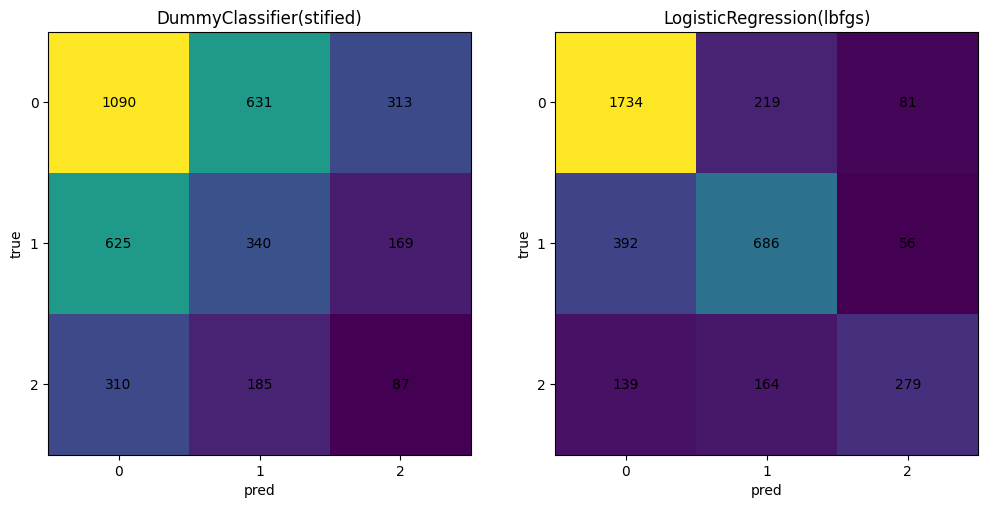

In [27]:
cmD = confusion_matrix(y_test, baselineSF.predict(X_test))
cmLR = confusion_matrix(y_test, log_reg.predict(X_test))

fig, (axCmD, axCmLR) = plt.subplots(nrows=1, ncols=2, figsize = (12, 6))

axCmD.imshow(cmD)
axCmD.set_title("DummyClassifier(stified)")
axCmD.set_xlabel("pred")
axCmD.set_ylabel("true")
axCmD.set_xticks((0, 1, 2))
axCmD.set_yticks((0, 1, 2))
for (i, j), v in np.ndenumerate(cmD):
        axCmD.text(j, i, str(v), ha="center", va="center")

axCmLR.imshow(cmLR)
axCmLR.set_title("LogisticRegression(lbfgs)")
axCmLR.set_xlabel("pred")
axCmLR.set_ylabel("true")
axCmLR.set_xticks((0, 1, 2))
axCmLR.set_yticks((0, 1, 2))
for (i, j), v in np.ndenumerate(cmLR):
        axCmLR.text(j, i, str(v), ha="center", va="center")

plt.savefig("artifacts\\figures\confusion_matrix for baselines")
plt.show()


Для вычисления метрики `f1` использовался подход `weighted`, так как он лучше остальных учитывает дисбаланс классов, а для подсчёта `ROC-AUC` подход `ovr`, так как он хорошо подходит для оценки моделей предсказывающих принадлежность объекта к конкретному классу.
На основе данных, полученных в результате бейслайнов, можно сделать вывод о нетривиальности задачи в качестве задачи ML, а также о наличии закономерностей которые не может выявить логистическая регрессия.